In [2]:
# PREPROCESSING  OF A DATA - SAME AS WITH LOGISTIC REGRESSION MODEL
import pandas as pd

df = pd.read_csv('../data/breast-cancer-data.csv')
df.head()
df.info()
# Removal of apostrophes
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.rstrip("'")

# Checking if I removed apostrophes
df.head()
# Filling in missing values in a way that we input the most frequent entries instead of missing ones
for column in ['node-caps', 'breast-quad']:
    most_frequent_value = df[column].mode()[0]
    df[column] = df[column].fillna(most_frequent_value)

    df.info()
##ENCODING
X = df.drop('class', axis=1)
y = df['class']
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# To see how function labeled our classes
print(dict(zip(le.classes_, le.transform(le.classes_))))
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# We define which columns are ordinal and in which order
ordinal_features = ['age', 'tumer-size', 'inv-nodes', 'deg-malig']
age_cats = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
tumer_size_cats = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54']
inv_nodes_cats = ['0-2', '3-5', '6-8', '9-11', '12-14', '15-17', '24-26']
deg_malig_cats = ['1', '2', '3']
ordinal_categories = [age_cats, tumer_size_cats, inv_nodes_cats, deg_malig_cats]

# We define whick columns are nominal
nominal_features = ['menopause', 'node-caps', 'breast', 'breast-quad', 'irradiate']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          286 non-null    object
 1   menopause    286 non-null    object
 2   tumer-size   286 non-null    object
 3   inv-nodes    286 non-null    object
 4   node-caps    278 non-null    object
 5   deg-malig    286 non-null    object
 6   breast       286 non-null    object
 7   breast-quad  285 non-null    object
 8   irradiate    286 non-null    object
 9   class        286 non-null    object
dtypes: object(10)
memory usage: 22.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          286 non-null    object
 1   menopause    286 non-null    object
 2   tumer-size   286 non-null    object
 3   inv-nodes    286 non-null    object
 4   node-

In [3]:
# --- RANDOM FOREST STEP 1: Build the Random Forest Pipeline ---
# Import necessary classes
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# 1. Define the preprocessor (this code is the same as before)
preprocessor = ColumnTransformer(transformers=[
    ('ord', OrdinalEncoder(categories=ordinal_categories), ordinal_features),
    ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_features)
])

# 2. Build the final pipeline
# This time, the classifier step is a RandomForestClassifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

In [4]:
# --- RANDOM FOREST STEP 2: Train and Evaluate the Random Forest Model ---
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train the entire pipeline on the training data
rf_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_pipeline.predict(X_test)

# Print performance metrics
print('--- Random Forest Performance ---')
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred_rf))
print('\nClassification Report:\n', classification_report(y_test, y_pred_rf, target_names=le.classes_))

--- Random Forest Performance ---
Accuracy: 0.6379310344827587

Confusion Matrix:
 [[33  8]
 [13  4]]

Classification Report:
                       precision    recall  f1-score   support

no-recurrence-events       0.72      0.80      0.76        41
   recurrence-events       0.33      0.24      0.28        17

            accuracy                           0.64        58
           macro avg       0.53      0.52      0.52        58
        weighted avg       0.60      0.64      0.62        58



In [5]:
# --- RANDOM FOREST STEP 3: Hyperparameter Tuning with GridSearchCV ---

# 1. Define the grid of parameters to search
# We are telling GridSearchCV to try different values for these hyperparameters.
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

In [6]:
# 2. Set up and run the Grid Search
from sklearn.model_selection import GridSearchCV

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_pipeline,
                           param_grid=param_grid,
                           cv=5,
                           scoring='recall',
                           n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters found: ", grid_search.best_params_)

/usr/local/Cellar/python@3.12/3.12.4/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/Cellar/python@3.12/3.12.4/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/Cellar/python@3.12/3.12.4/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setup

Best parameters found:  {'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}


In [7]:
# 3. Evaluate the best model found by the grid search
# The grid_search object itself behaves like the best model it found
y_pred_tuned_rf = grid_search.predict(X_test)

# Print the performance metrics
print('\n--- Tuned Random Forest Performance ---')
print('Accuracy:', accuracy_score(y_test, y_pred_tuned_rf))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred_tuned_rf))
print('\nClassification Report:\n', classification_report(y_test, y_pred_tuned_rf, target_names=le.classes_))


--- Tuned Random Forest Performance ---
Accuracy: 0.6724137931034483

Confusion Matrix:
 [[33  8]
 [11  6]]

Classification Report:
                       precision    recall  f1-score   support

no-recurrence-events       0.75      0.80      0.78        41
   recurrence-events       0.43      0.35      0.39        17

            accuracy                           0.67        58
           macro avg       0.59      0.58      0.58        58
        weighted avg       0.66      0.67      0.66        58



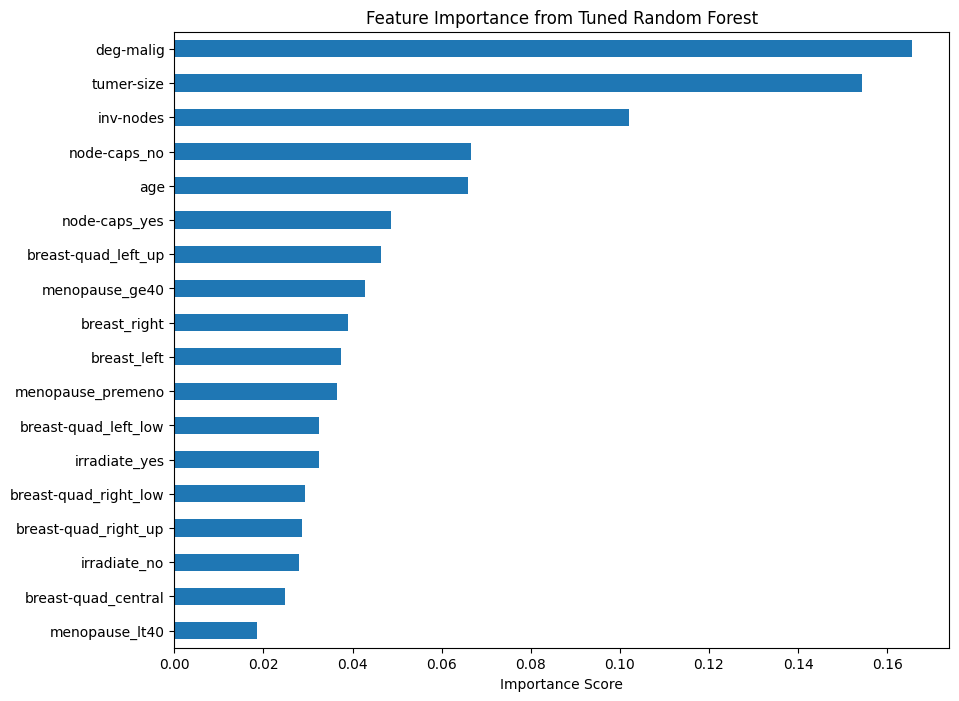

In [8]:
# --- RANDOM FOREST STEP 4: Analyze Feature Importance ---
# We want to see which features our best Random Forest model found most important.

import pandas as pd
import matplotlib.pyplot as plt

# Get the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Get the preprocessor step from the pipeline
preprocessor = best_rf_model.named_steps['preprocessor']

# Get the list of feature names after one-hot encoding
# This is a bit complex, but necessary to match names with importance scores
ohe_feature_names = preprocessor.named_transformers_['nom'].get_feature_names_out(nominal_features)
all_feature_names = ordinal_features + list(ohe_feature_names)

# Get the importance scores
importances = best_rf_model.named_steps['classifier'].feature_importances_

# Create a pandas Series for easy plotting
feature_importance_series = pd.Series(importances, index=all_feature_names)

# Plot the feature importances
plt.figure(figsize=(10, 8))
feature_importance_series.sort_values().plot(kind='barh')
plt.title('Feature Importance from Tuned Random Forest')
plt.xlabel('Importance Score')
plt.show()